In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import permutation as pm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

### Model

We will use the same model with different input and output shapes for differnet datasets.

In [2]:
class MLP(nn.Module):
    def __init__(self,r,c):
        super(MLP,self).__init__()
        self.r =r
        self.c=c
        self.layer_1 = nn.Linear(self.r*self.c,self.r*self.c,bias=False)
        #self.relu = nn.ReLU()

    def forward(self, input):
        out = self.layer_1(input)

        return out

## Learning to UnPermute MNIST Images

In [3]:
#rows and column
r,c =28,28
# Initialize the permutation matrix 
p_m = pm.Create(r,c)

# Lets load the data set from script

OriginalTrain, OriginalTest, PermutedTrain, PermutedTest, _,_ = p_m.MNIST()

# Normalize the images by dividing them 255

OriginalTrain, OriginalTest, PermutedTrain, PermutedTest = OriginalTrain/255, OriginalTest/255, PermutedTrain/255, PermutedTest/255

if torch.cuda.is_available:
    OriginalTrain, OriginalTest = OriginalTrain.cuda(), OriginalTest.cuda()
    PermutedTrain, PermutedTest  = PermutedTrain.cuda(), PermutedTest.cuda()

In [4]:
# Initialize the model optimizer and loss

mnistModel = MLP(r,c)
#initialize weights from all 1
mnistModel.layer_1.weight.data = torch.ones((r*c, r*c)).cuda()
if torch.cuda.is_available:
    mnistModel = mnistModel.cuda()


loss = nn.MSELoss()

optimizer = optim.SGD(mnistModel.parameters(),lr=0.001)

#store loss for each iteration in a list
loss_history = []

In [5]:
epochs = 5
batch_size = 1
tb = time.time()
for epoch in range(epochs):
    # to shuffle the images in each epoch
    index = np.random.permutation(OriginalTrain.shape[0])
    
    for i in range(len(index)):
        # inp to model
        inp = PermutedTrain[ [index[i*batch_size : (i*batch_size)+batch_size]] ].flatten(start_dim=1)
        
        output = mnistModel.forward(inp)
        
        l = loss(output, OriginalTrain[ [index[i*batch_size : (i*batch_size)+batch_size]] ].flatten(start_dim=1) )
        #print(l.item())
        loss_history.append(l.item())
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
    print(f" Epoch : {epoch} Loss {np.sum(loss_history)/len(loss_history)} Time : {(time.time()-tb)/60} min ")
        

 Epoch : 0 Loss 1085.885970059318 Time : 0.5475087285041809 min 
 Epoch : 1 Loss 569.2742948224259 Time : 1.1518274545669556 min 
 Epoch : 2 Loss 390.60222386692703 Time : 1.7523231625556945 min 
 Epoch : 3 Loss 299.00922461504484 Time : 2.3189639488856 min 
 Epoch : 4 Loss 243.0460960636252 Time : 2.879515786965688 min 


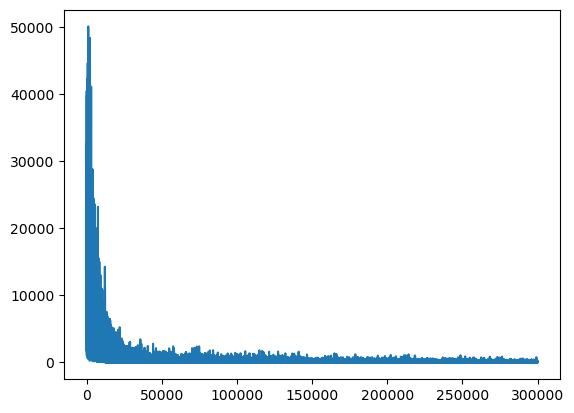

In [6]:
plt.plot(loss_history)


(-0.5, 27.5, 27.5, -0.5)

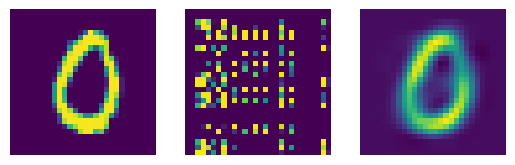

In [7]:
number = 1001
plt.subplot(1,3,1)
plt.imshow(OriginalTest[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTest[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(mnistModel.forward(PermutedTest[number].flatten()).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

## Learning to UnPermute FashionMNIST Images

In [8]:
# Load the data


# Lets load the data set from script

OriginalTrainF, OriginalTestF, PermutedTrainF, PermutedTestF, _,_ = p_m.FashionMNIST()

# Normalize the images by dividing them 255

OriginalTrainF, OriginalTestF, PermutedTrainF, PermutedTestF = OriginalTrainF/255, OriginalTestF/255, PermutedTrainF/255, PermutedTestF/255

if torch.cuda.is_available:
    OriginalTrainF, OriginalTestF = OriginalTrainF.cuda(), OriginalTestF.cuda()
    PermutedTrainF, PermutedTestF  = PermutedTrainF.cuda(), PermutedTestF.cuda()

### Lets try the model trained for mnist

(-0.5, 27.5, 27.5, -0.5)

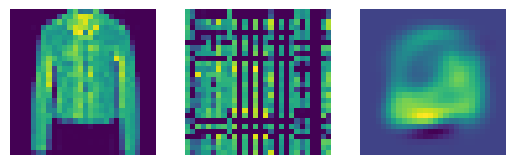

In [9]:
plt.subplot(1,3,1)
plt.imshow(OriginalTestF[10].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTestF[10].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(mnistModel.forward(PermutedTestF[0].flatten()).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

It does not work as expected. But if A model is trained on FashionMNIST it will work for mnist as well. Reason for this is mnist images are low in sparsity (mostly pixel values are 0, even shuffling them will result in zeros on other place, but now was it shuffled or not), so model can not learn to unpermute.

In [10]:
# Initialize the model optimizer and loss

fmnistModel = MLP(r,c)
#initialize weights from all 1
fmnistModel.layer_1.weight.data = torch.ones((r*c, r*c)).cuda()
if torch.cuda.is_available:
    fmnistModel = fmnistModel.cuda()


lossf = nn.MSELoss()

optimizerf = optim.SGD(fmnistModel.parameters(),lr=0.001)

#store loss for each iteration in a list
loss_historyf = []

In [11]:
epochs = 20
batch_size = 1
tb = time.time()
for epoch in range(epochs):
    # to shuffle the images in each epoch
    index = np.random.permutation(OriginalTrainF.shape[0])
    
    for i in range(len(index)):
        # inp to model
        inp = PermutedTrainF[ [index[i*batch_size : (i*batch_size)+batch_size]] ].flatten(start_dim=1)
        
        output = fmnistModel.forward(inp)
        
        l = lossf(output, OriginalTrainF[ [index[i*batch_size : (i*batch_size)+batch_size]] ].flatten(start_dim=1) )
        #print(l.item())
        loss_historyf.append(l.item())
        
        optimizerf.zero_grad()
        l.backward()
        optimizerf.step()
        
    print(f" Epoch : {epoch} Loss {np.sum(loss_historyf)/len(loss_historyf)} Time : {(time.time()-tb)/60} min ")
        

 Epoch : 0 Loss 1810.3829355452986 Time : 0.5414487640062968 min 
 Epoch : 1 Loss 927.3496229908525 Time : 1.0825263261795044 min 
 Epoch : 2 Loss 628.2906804425127 Time : 1.6208510716756186 min 
 Epoch : 3 Loss 477.47788685468464 Time : 2.158494544029236 min 
 Epoch : 4 Loss 386.2773905942072 Time : 2.6973408579826357 min 
 Epoch : 5 Loss 325.03692278570117 Time : 3.2440081000328065 min 
 Epoch : 6 Loss 281.0012702119113 Time : 3.7821517984072366 min 
 Epoch : 7 Loss 247.7686188783766 Time : 4.321780622005463 min 
 Epoch : 8 Loss 221.7686097522604 Time : 4.861084524790446 min 
 Epoch : 9 Loss 200.85333847965342 Time : 5.400252878665924 min 
 Epoch : 10 Loss 183.65020673069105 Time : 5.940811002254486 min 
 Epoch : 11 Loss 169.24220889852418 Time : 6.481523287296295 min 
 Epoch : 12 Loss 156.99218435782828 Time : 7.023508067925771 min 
 Epoch : 13 Loss 146.44402629394094 Time : 7.567670226097107 min 
 Epoch : 14 Loss 137.26188192228602 Time : 8.111489101250966 min 
 Epoch : 15 Loss 129

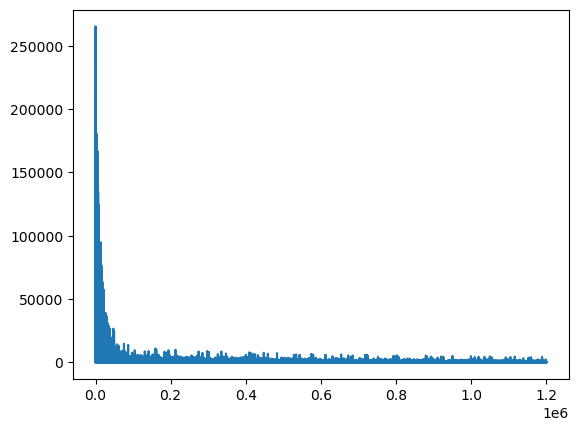

In [12]:
plt.plot(loss_historyf)

(-0.5, 27.5, 27.5, -0.5)

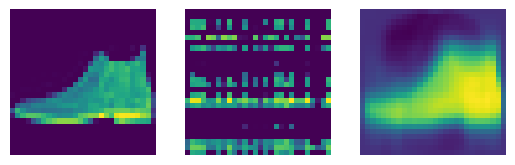

In [13]:
number = 0
plt.subplot(1,3,1)
plt.imshow(OriginalTestF[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTestF[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(fmnistModel.forward(PermutedTestF[number].flatten()).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

### Now lets try fashionMNIST model for MNIST

(-0.5, 27.5, 27.5, -0.5)

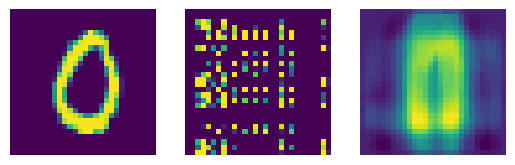

In [14]:
number = 1001
plt.subplot(1,3,1)
plt.imshow(OriginalTest[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTest[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(fmnistModel.forward(PermutedTest[number].flatten()).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

## Learning to UnPermute CIFAR10 grayscale Images

In [15]:
# Load the data



# Lets load the data set from script

OriginalTrainC, OriginalTestC, PermutedTrainC, PermutedTestC, _,_ = p_m.CIFAR10()

# Normalize the images by dividing them 255

#OriginalTrainC, OriginalTestC, PermutedTrainC, PermutedTestC = OriginalTrainC/255, OriginalTestC/255, PermutedTrainC/255, PermutedTestC/255

if torch.cuda.is_available:
    OriginalTrainC, OriginalTestC = OriginalTrainC.cuda(), OriginalTestC.cuda()
    PermutedTrainC, PermutedTestC  = PermutedTrainC.cuda(), PermutedTestC.cuda()

Files already downloaded and verified
Files already downloaded and verified


### Lets try fashionMnist model for cifar10 images

(-0.5, 27.5, 27.5, -0.5)

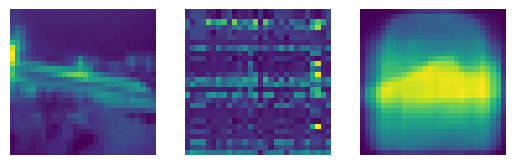

In [16]:
number = 1001
plt.subplot(1,3,1)
plt.imshow(OriginalTestC[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTestC[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(fmnistModel.forward(PermutedTestC[number].flatten()).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

In [17]:
# Initialize the model optimizer and loss

cifarModel = MLP(r,c)
#initialize weights from all 1
cifarModel.layer_1.weight.data = torch.ones((r*c, r*c)).cuda()
if torch.cuda.is_available:
    cifarModel = cifarModel.cuda()


lossc = nn.MSELoss()

optimizerc = optim.SGD(cifarModel.parameters(),lr=0.01)

#store loss for each iteration in a list
loss_historyc = []

In [18]:
epochs = 10
batch_size = 1
tb = time.time()
for epoch in range(epochs):
    # to shuffle the images in each epoch
    #lets just use 5000 or 50000 images
    index = np.random.permutation(50000)
    
    for i in range(len(index)):
        # inp to model
        inp = PermutedTrainC[ [index[i*batch_size : (i*batch_size)+batch_size]] ].flatten(start_dim=1)
        
        output = cifarModel.forward(inp)
        
        l = lossc(output, OriginalTrainC[ [index[i*batch_size : (i*batch_size)+batch_size]] ].flatten(start_dim=1) )
        #print(l.item())
        loss_historyc.append(l.item())
        
        optimizerc.zero_grad()
        l.backward()
        optimizerc.step()
        
    print(f" Epoch : {epoch} Loss {np.sum(loss_historyc)/len(loss_historyc)} Time : {(time.time()-tb)/60} min ")
  

 Epoch : 0 Loss 307.52218930106585 Time : 0.4583491245905558 min 
 Epoch : 1 Loss 153.77268521534668 Time : 0.9253832379976908 min 
 Epoch : 2 Loss 102.51935625476845 Time : 1.3900471727053325 min 
 Epoch : 3 Loss 76.8917900637842 Time : 1.8524128913879394 min 
 Epoch : 4 Loss 61.514878113504544 Time : 2.313640077908834 min 
 Epoch : 5 Loss 51.263411684882584 Time : 2.7723588983217877 min 
 Epoch : 6 Loss 43.94082216843791 Time : 3.237088469664256 min 
 Epoch : 7 Loss 38.44880634049698 Time : 3.7189026912053427 min 
 Epoch : 8 Loss 34.17718754535637 Time : 4.182506680488586 min 
 Epoch : 9 Loss 30.759855674955546 Time : 4.643106361230214 min 


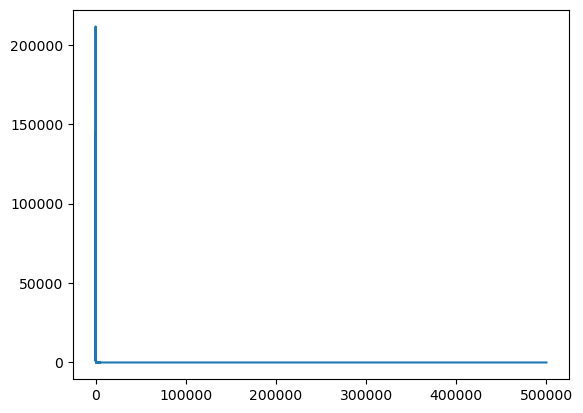

In [19]:
plt.plot(loss_historyc)

(-0.5, 27.5, 27.5, -0.5)

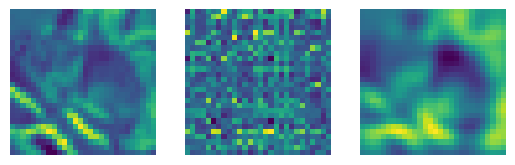

In [20]:
number = 2018
plt.subplot(1,3,1)
plt.imshow(OriginalTestC[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTestC[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cifarModel.forward(PermutedTestC[number].flatten()).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

### Lets try MNIST and FashionMNIST with CIFAR model

(-0.5, 27.5, 27.5, -0.5)

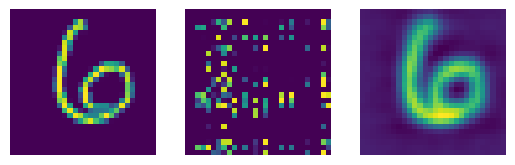

In [21]:
number = 100
plt.subplot(1,3,1)
plt.imshow(OriginalTest[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTest[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cifarModel.forward(PermutedTest[number].flatten()*255).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

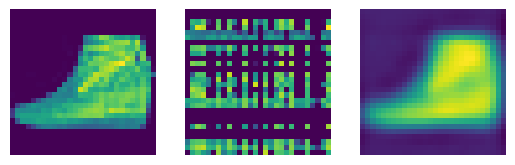

In [22]:
number = 250
plt.subplot(1,3,1)
plt.imshow(OriginalTestF[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(PermutedTestF[number].detach().cpu().numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cifarModel.forward(PermutedTestF[number].flatten()*255).reshape(r,c).detach().cpu().numpy() )
plt.axis('off')